In [1]:
# -*- coding: utf-8 -*-
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
import json
from glob import glob
import cv2
from collections import defaultdict

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

from models import Densenet
from efficientnet_pytorch import EfficientNet


In [2]:
seed = 5487
device = 'cuda:0'
if not torch.cuda.is_available(): device='cpu'
load_model_path = './{17}_loss{1.6857}.pth'
torch.manual_seed(seed)
np.random.seed(seed)

with open('./word2label.json', 'r', encoding='utf-8') as f:
    word2label = json.load(f)
label2word = {val:key for key, val in word2label.items()}

label2word2 = dict()
with open('./idx2class.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines()
    for idx, l in enumerate(lines):
        label2word2[idx] = l.strip()

label2word3 = dict()
with open('./idx2class_revised.dat', 'r', encoding='utf-8') as f:
    lines = f.readlines()
    for idx, l in enumerate(lines):
        label2word3[idx] = l.strip()

first_model = '{2}_loss.pth'
second_model = 'gridmask2.pt'
third_model = 'efficientnet_b3.pt'
forth_model = 'affine.pt'

# model1 = Densenet(len(word2label)).to(device)
# model1.load_state_dict(torch.load(first_model, map_location=torch.device('cpu')))
# model1.eval()       

model2 = EfficientNet.from_name('efficientnet-b3')
model2._fc = nn.Linear(1536, 800)
model2.load_state_dict(torch.load(second_model, map_location=torch.device('cpu')))
model2.eval()

# model3 = EfficientNet.from_name('efficientnet-b3')
# model3._fc = nn.Linear(1536, 800)
# model3.load_state_dict(torch.load(third_model, map_location=torch.device('cpu')))
# model3.eval()

model4 = EfficientNet.from_name('efficientnet-b3')
model4._fc = nn.Linear(1536, 800)
model4.load_state_dict(torch.load(forth_model, map_location=torch.device('cpu')))
model4.eval()

softmax = nn.Softmax(dim=1)

In [3]:
def preprocess_img(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, thre_img = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    thre_img = cv2.fastNlMeansDenoising(thre_img, h=13, searchWindowSize=7)
    
    thre_img = cv2.fastNlMeansDenoising(thre_img, h=13, searchWindowSize=7)
    kernel = np.ones((3,3), np.uint8)
    thre_img = cv2.erode(thre_img, kernel, iterations = 1)

    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 13))
    dilate = cv2.dilate(thre_img, rect_kernel, iterations = 1)
    
    contours, hierarchy = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if len(contours) == 0: bound = cv2.resize(img, (50,50))
    else:
        max_area = -1
        bx, by, bw, bh = None, None, None, None
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            if w * h > max_area:
                bx, by, bw, bh = x, y, w, h
                max_area = w * h

        bound = cv2.resize(img[by:by+bh, bx:bx+bw], (50, 50))
    
    _, bound = cv2.threshold(bound, 0, 255, cv2.THRESH_OTSU)
    bound = cv2.cvtColor(bound, cv2.COLOR_GRAY2BGR)

    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    bound = transform(bound)
    return bound

def preprocess3_img(img):
    img = img[:, :, ::-1]
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img = transform(img)
    return img

Loading image  1623145703_img.jpg


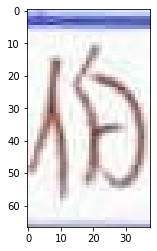

gridmask ('伯', 0.9814836382865906)	affine ('伯', 0.996823787689209)	Ensemble ('伯', 0.9884564334695987)

Loading image  1623146561_img.jpg


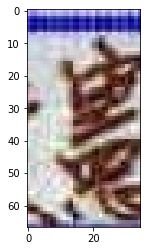

gridmask ('憲', 0.9977263808250427)	affine ('憲', 0.7869517207145691)	Ensemble ('憲', 0.9019197171384638)

Loading image  1623146562_img.jpg


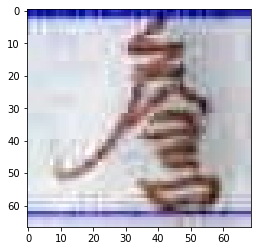

gridmask ('詹', 0.9994745850563049)	affine ('詹', 0.9999181032180786)	Ensemble ('詹', 0.9996761842207476)

Loading image  1623146564_img.jpg


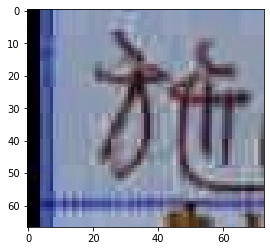

gridmask ('施', 0.9878085851669312)	affine ('施', 0.9995817542076111)	Ensemble ('施', 0.9931600256399672)

Loading image  1623146565_img.jpg


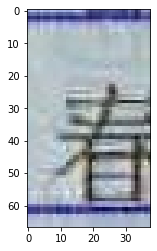

gridmask ('春', 0.966152012348175)	affine ('春', 0.9927811026573181)	Ensemble ('春', 0.9782561443068765)

Loading image  1623146568_img.jpg


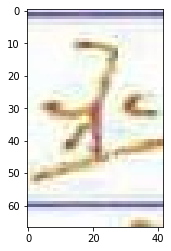

gridmask ('丞', 0.999692440032959)	affine ('丞', 0.9999947547912598)	Ensemble ('丞', 0.9998298558321866)

Loading image  1623146569_img.jpg


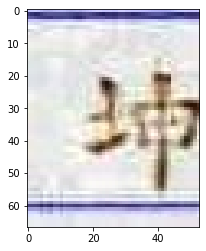

gridmask ('坤', 0.9540819525718689)	affine ('坤', 0.9969784021377563)	Ensemble ('坤', 0.9735803387381812)

Loading image  1623146570_img.jpg


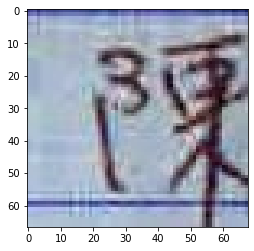

gridmask ('陳', 0.9994901418685913)	affine ('陳', 0.9961367249488831)	Ensemble ('陳', 0.997965861450542)

Loading image  1623146572_img.jpg


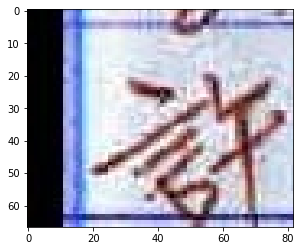

gridmask ('許', 0.9796122908592224)	affine ('許', 0.9992979764938354)	Ensemble ('許', 0.9885603297840464)

Loading image  1623146573_img.jpg


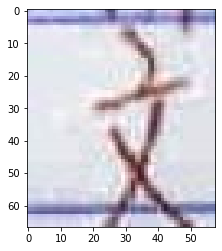

gridmask ('文', 0.9992507100105286)	affine ('文', 0.9983733892440796)	Ensemble ('文', 0.9988519278439608)

Loading image  1623146574_img.jpg


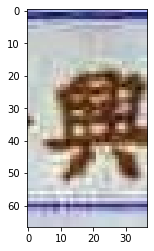

gridmask ('興', 0.996639609336853)	affine ('興', 0.9797866344451904)	Ensemble ('興', 0.9889791662042788)

Loading image  1623146576_img.jpg


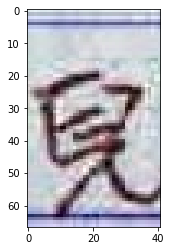

gridmask ('兒', 0.9998262524604797)	affine ('兒', 0.9935184121131897)	Ensemble ('兒', 0.9969590523026206)

Loading image  1623146577_img.jpg


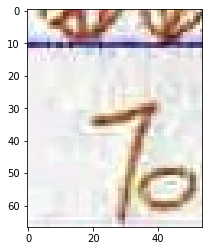

gridmask ('石', 0.9963247179985046)	affine ('石', 0.9924938678741455)	Ensemble ('石', 0.9945834224874323)

Loading image  1623146578_img.jpg


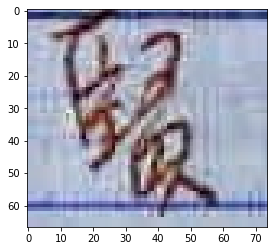

gridmask ('賢', 0.9191663265228271)	affine ('賢', 0.9959580302238464)	Ensemble ('賢', 0.9540716463869267)

Loading image  1623146579_img.jpg


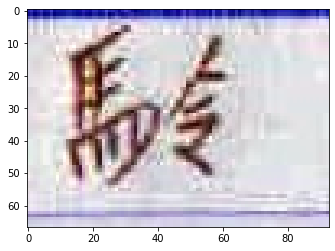

gridmask ('駿', 0.97482830286026)	affine ('駿', 0.9903958439826965)	Ensemble ('駿', 0.9819044579159129)

Loading image  1623146581_img.jpg


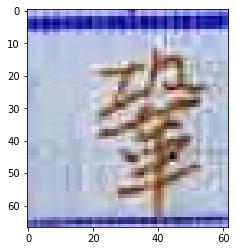

gridmask ('華', 0.39973169565200806)	affine ('華', 0.6440828442573547)	Ensemble ('華', 0.5108003995635292)

Loading image  1623146583_img.jpg


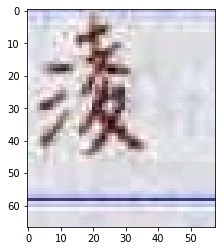

gridmask ('凌', 0.9815484881401062)	affine ('凌', 0.9984496831893921)	Ensemble ('凌', 0.9892308495261453)

Loading image  1623146584_img.jpg


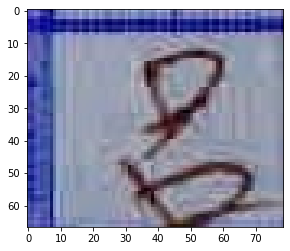

gridmask ('呂', 0.9993104934692383)	affine ('呂', 0.9994358420372009)	Ensemble ('呂', 0.9993674700910392)

Loading image  1623146586_img.jpg


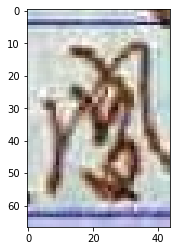

gridmask ('鳳', 0.903862714767456)	affine ('周', 0.5457119941711426)	Ensemble ('鳳', 0.597735433415933)

Loading image  1623146588_img.jpg


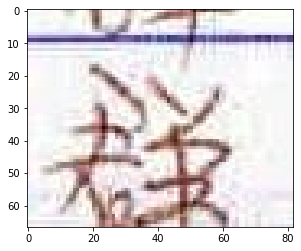

gridmask ('群', 0.40797868371009827)	affine ('群', 0.41402313113212585)	Ensemble ('群', 0.4107261598110199)

Loading image  1623146589_img.jpg


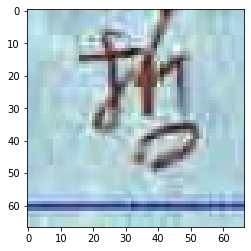

gridmask ('哲', 0.9998096823692322)	affine ('哲', 0.9999920129776001)	Ensemble ('哲', 0.9998925599184901)

Loading image  1623146590_img.jpg


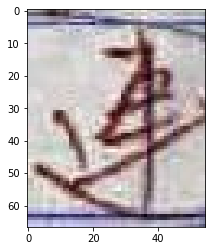

gridmask ('連', 0.9938807487487793)	affine ('連', 0.9507465362548828)	Ensemble ('連', 0.9742742885242808)

Loading image  1623146594_img.jpg


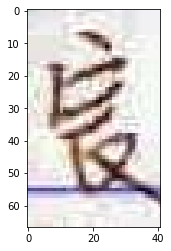

gridmask ('宸', 0.7900245785713196)	affine ('宸', 0.9438629150390625)	Ensemble ('宸', 0.8599510951475663)

Loading image  1623146596_img.jpg


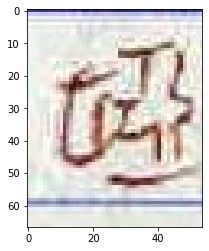

gridmask ('經', 0.20334172248840332)	affine ('歐', 0.33090969920158386)	Ensemble ('歐', 0.15445477633991023)

Loading image  1623146599_img.jpg


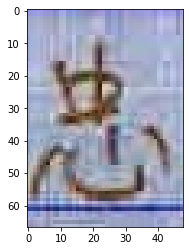

gridmask ('忠', 0.9799678325653076)	affine ('忠', 0.9966256618499756)	Ensemble ('忠', 0.9875395731492475)

Loading image  1623146610_img.jpg


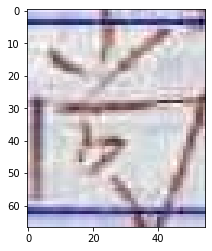

gridmask ('尚', 0.9918248057365417)	affine ('尚', 0.9926642775535583)	Ensemble ('尚', 0.9922063838351854)

Loading image  1623146613_img.jpg


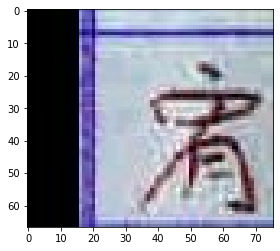

gridmask ('宥', 0.9986157417297363)	affine ('宥', 0.9999827146530151)	Ensemble ('宥', 0.9992370930584993)

Loading image  1623146615_img.jpg


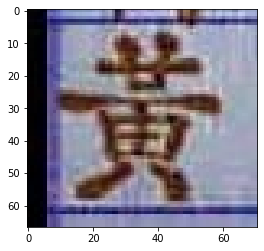

gridmask ('黃', 0.9963430762290955)	affine ('黃', 0.9903303384780884)	Ensemble ('黃', 0.9936100136150011)

Loading image  1623146618_img.jpg


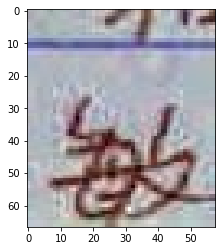

gridmask ('敏', 0.9982330799102783)	affine ('敏', 0.9951409101486206)	Ensemble ('敏', 0.9968275482004337)

Loading image  1623146623_img.jpg


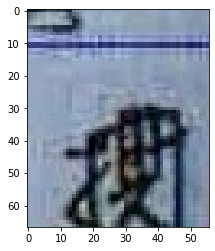

gridmask ('樓', 0.5144009590148926)	affine ('博', 0.21445508301258087)	Ensemble ('樓', 0.2835690161551941)

Loading image  1623146641_img.jpg


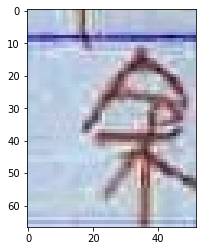

gridmask ('余', 0.9581819772720337)	affine ('余', 0.9989309906959534)	Ensemble ('余', 0.9767042561010881)



In [4]:
def predict_img(img, model, preprocess_func, mapping):
    img = preprocess_func(img).to(device)
    img = torch.unsqueeze(img, dim=0)
    with torch.no_grad():
        out = model(img)
        out = softmax(out)
        pred_matrix = defaultdict()
        for idx, val in enumerate(out[0]):
            pred_matrix[mapping[idx]] = val.item()

    pred_matrix = {word: pred_matrix[word] for word in  sorted(pred_matrix.keys())}
    return pred_matrix
#         val, pred = torch.max(out, 1)
#         pred = mapping[int(pred.item())]
#     return pred, val

def find_max_prob_word(pred_list, weight=None):
    pred_word, pred_val = None, -1
    pred_cnt = len(pred_list)
    if weight is None: weight = [1 for _ in range(pred_cnt)]
        
    words = pred_list[0].keys()
    for word in words:
        val = 0
        for p_id, pred in enumerate(pred_list):
            val += pred[word] * weight[p_id]
        if val > pred_val:
            pred_word = word
            pred_val = val
    
    return pred_word, pred_val / sum(weight)
        
path = './0608/image'
img_paths = sorted(glob(os.path.join(path, '*.jpg')))

for img_path in img_paths:
#     if int(img_path.split('/')[-1].split('_')[0]) < 1621936977: continue
    img = cv2.imread(img_path, 1)
    assert(img is not None)
    print('Loading image ', img_path.split('/')[-1])
#     ans1 = predict_img(img, model1, preprocess_img, label2word)
    ans2 = predict_img(img, model2, preprocess3_img, label2word3)
#     ans3 = predict_img(img, model3, preprocess3_img, label2word2)
    ans4 = predict_img(img, model4, preprocess3_img, label2word3)
    
#     pred1 = find_max_prob_word([ans1])
    pred2 = find_max_prob_word([ans2])
#     pred3 = find_max_prob_word([ans3])
    pred4 = find_max_prob_word([ans4])
    pred5 = find_max_prob_word([ans2, ans4], [1.2, 1])
    
    plt.imshow(img)
    plt.show()
    print('gridmask {}\taffine {}\tEnsemble {}\n'.format(pred2, pred4, pred5))
#     print('Densenet {}\t gridmask {}\t efficientnet {}\taffine {}\tEnsemble {}\n'.format(pred1, pred2, pred3, pred4, pred5))
#     input()